In [ ]:
import pprint as pp
import random
from itertools import permutations, product

import matplotlib as mpl
import matplotlib.pyplot as plt
# Imports
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
from cycler import cycler

sns.set_style("white")

# 02443 Stochastic Simulation - Project 2
## Simulation of patient flow in hospitals

Group number 4

23-06-2022

<center>

| Students                      | ID        |
| -------------                 |:---------:|
| Mie REDACTED                  | REDACTED  |
| Rasmus REDACTED               | REDACTED  |
| Benjamin Starostka Jakobsen   | s184198   |
| Muhammad REDACTED             | REDACTED  |
| Victor REDACTED               | REDACTED  |

</center>

# Introduction

In this project, we want to simulate patient flow in a small hospital. The aim is to decide how many resources each ward in the hospital should have from a technical perspective. This will be performed by deriving a simulation model that evaluates the implications of employing a specific distribution of bed resources.

This project covers a flow of inpatients, including patients that stay for at least one night. The patient flow starts at the emergency department, where each patient is relocated to different wards according to their respective diagnoses. The patient will stay and receive treatment from the allocated ward. The wards follow a type of Erlang loss system, a queueing system where a lack of capacity leads to rejection or relocation to alternative wards.

We consider a particular year, and due to a pandemic, the hospital has been forced to create a new temporary ward and relocate staff and beds, leading to further pressure. 

The report includes explanations of algorithms, reasons behind some design choices and code cells in Python used to implement everything mentioned.


# Parameters

We know that the system has the following parameters and distributions. They are the results of assumptions on patient's behaviour.

$N =6$ : The number of different wards and patient types.

$ward\_types_N$ :  The hospital has 6 wards $W=\{A,B,C,D,E,F^*\}$

$patient\_types_N$ : The hospital has 6 types of patients $P=\{A,B,C,D,E,F^*\}$, that should be admitted into their respective wards.

$bed\_capacity_N$ : Each ward has a fixed bed capacity. Before opening the new ward $F^*$, the bed capacity was $C=\{50,40,30,20,20,0\}$

$arrival\_per\_day_N$ : The exponentially distributed inter-arrival time rate $\lambda_i$ (Patients of type $i \in P$ arrive to the hospital following a Poisson process with rate $\lambda_i$).

$mean\_length\_stay_N$ :  The exponentially distributed duration of stay in the hospital with scale $1/\mu_i$  of patients of type $i$.


$prob\_relocate_{NxN}$ : Probabillity $p_{ij}$ for a patient $i \in P$ to be relocated to an alternative ward $j \in W$, if all beds are occupied in the prefered ward $i \in W$. If all beds are occupied in ward $j$ the patient is lost from the system.

$urgency\_points_N$ : The cost or penalty for a ward if a patient $i$ is rejected from ward $i$.

Notice how the urgency points for patient type F* not allocated to ward F* is *not relevant* and set to 0. This is because the end goal is to have nearly all F* patients treated there (at least 95%). Notice also how the 6th column in the probability to be relocated matrix has 0 for every row. This means that only patients of type F* will be allocated bed in ward F*, no one else will be re-allocated there. This make sense knowing that this ward is created to deal with a countrywide epidemic, and it is thus seperated, confined, from the others wards and patients to prevent contagion. 

In [ ]:
ward_types = [0, 1, 2, 3, 4, 5]  # ['A', 'B', 'C', 'D', 'E', 'F*']
patient_types = [0, 1, 2, 3, 4, 5]
int_to_letter = {0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F*"}
letter_to_int = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F*": 5}

# Table 1: Parameters associated with each ward and patient type.
bed_capacity = [55, 40, 30, 20, 20, 0]  # M_i
arrival_per_day = [14.5, 11.0, 8.0, 6.5, 5.0, 13.0]  # lambda_i
mean_length_stay = [2.9, 4.0, 4.5, 1.4, 3.9, 2.2]  # 1/mu_i
urgency_points = [7, 5, 2, 10, 5, 0]

# Table 2: Probability, pij, of relocating a patient of type i ∈ P to an alternative Ward j ∈ W.
prob_relocate = [
    [0.00, 0.05, 0.10, 0.05, 0.80, 0.00],
    [0.20, 0.00, 0.50, 0.15, 0.15, 0.00],
    [0.30, 0.20, 0.00, 0.20, 0.30, 0.00],
    [0.35, 0.30, 0.05, 0.00, 0.30, 0.00],
    [0.20, 0.10, 0.60, 0.10, 0.00, 0.00],
    [0.20, 0.20, 0.20, 0.20, 0.20, 0.00],
]
prob_relocate = np.array(prob_relocate)

# Modelling the system

## Simulating patient arrivals

We wish to build a simulation model for the patient flow in the hospital system.

The arrivals of patients are simulated for a given number of days. 
For each patient type, one inter-arrival time $\Delta_i$ is sampled from their respective exponential distribution (with scale $1/\lambda_i$).
Then, the main loop works as follows:

 -  Identify the patient with the lowest inter-arrival time $\Delta_{min}$, $i.e.$ the closest in time to come to the hospital. 

 - Move forward in time. Increase the time by $\Delta_{min}$ and update all the inter-arrival times $\Delta_i - \Delta_{min}$.

 - Log the arrival of the patient: its type, its arrival time and its length of stay (sampled from an exponential distribution with scale $1/\mu_i$)

 - Replace the selected patient by sampling the next inter-arrival time of same patient type.

- Terminate if the time is above the given number of days.

We simulate the arrivals of patient during 1 year (365 days).

Note that in practice the simulation is done for one additional day at the beginning, during when no patient is logged. This is done to remove any initialization artifacts due to first sampling all inter-arrival times at the same time. 

In [ ]:
def initialize_patients(days):
    global patient_types
    global arrival_per_day
    global mean_length_stay

    dic = {"Patient type": [], "Arrival time": [], "Length of stay": []}
    inter_arrival_clocks = np.array(
        [np.random.exponential(scale=1 / arrival_per_day[i]) for i in patient_types]
    )

    # Do 1 fictitious day at the beginning of the simulation to eliminate initialization artifact
    t = -1
    while t < days:
        # Select next patient (one with shortest time to come to hospital)
        idx = np.argmin(inter_arrival_clocks)
        delta = inter_arrival_clocks[idx]

        # Update time and clocks
        t += delta
        inter_arrival_clocks -= delta

        # Register patient
        if t > 0 and t < days:
            dic["Patient type"].append(idx)
            dic["Arrival time"].append(t)
            dic["Length of stay"].append(
                np.random.exponential(scale=mean_length_stay[idx])
            )

        # Re-initialize next patient of that type
        inter_arrival_clocks[idx] = np.random.exponential(
            scale=1 / arrival_per_day[idx]
        )

    df = pd.DataFrame(dic)
    df["Patient type"] = pd.Categorical(df["Patient type"])
    return df


df = initialize_patients(days=365)

We can visualize the patient flow in multiple ways. First, let us visualize below the length of stay of each patient along their arrival time, colored by patient type. For visibility purpose, this is done for the first day, first week and the entire year. 

In [ ]:
def visualize_arrivals(df, days=1, log=False):
    # Filter the first day
    df = df[df["Arrival time"] < days]

    fig, ax = plt.subplots(1, 1, figsize=(15, 3))
    sns.scatterplot(
        data=df,
        x="Arrival time",
        y="Length of stay",
        hue="Patient type",
        palette=["C0", "C1", "C2", "C3", "C4", "C5"],
        ax=ax,
    )
    if log:
        ax.set_yscale("log")
    ax.set(
        title=f"Arrivals during the first {days} day(s)",
        ylabel="Length of stay (in days)",
        xlabel="Arrival time (in days)",
    )

    # Pretty legend
    current_handles, current_labels = plt.gca().get_legend_handles_labels()
    ax.legend(
        current_handles,
        ["A", "B", "C", "D", "E", "F*"],
        loc="upper center",
        bbox_to_anchor=(1.0, 0.85),
        ncol=1,
        fancybox=True,
        shadow=True,
    )

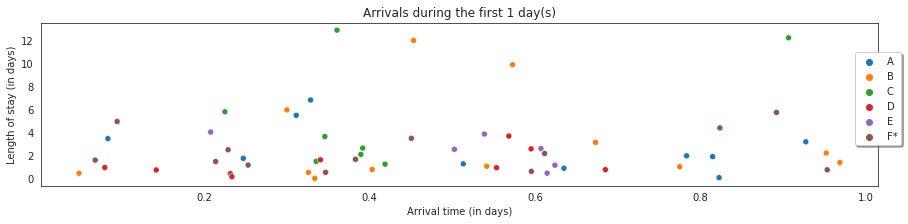

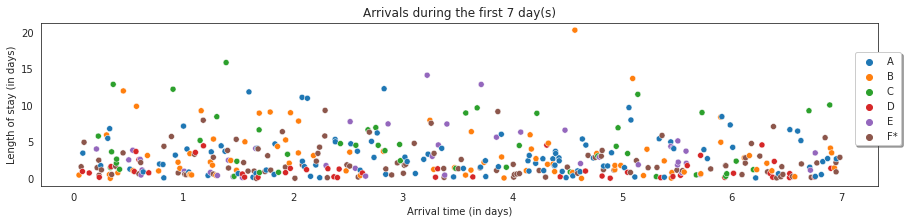

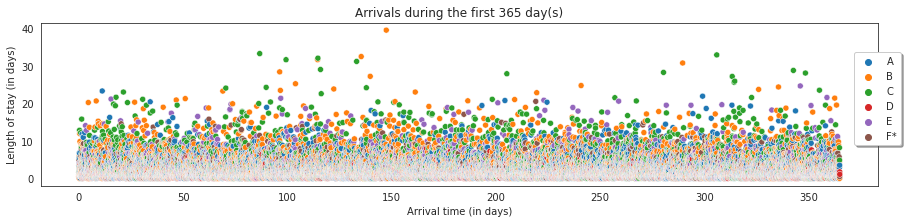

In [ ]:
visualize_arrivals(df, days=1)
visualize_arrivals(df, days=7)
visualize_arrivals(df, days=365)

On the  $x$-axis, one can see that each patient type's arrivals follow their own Poisson process of rate $\lambda_i$. Patient types with higher rate ($\lambda_A=14.5$, $\lambda_B=11$, $\lambda_{F^*}=13$) are a lot more frequent than types with lower rate ($\lambda_D=6.5$, $\lambda_E=5$). Overall, this creates for the arrival times a mixture of 6 Poisson processes. 

On the $y$-axis, one can observe the overall length of stay distribution. Most of the stay duration are short, between 0 and 5 days, but some stays can last a lot longer.

But is our simulation behaving correctling, as we would expect? To answer that, one can test our observed values with a $\chi^2$-test. 

The expected number of patients per type can be computed using their arrival per day rates $\lambda_i$. The intuitive way to do it would be to simply multiply this rate by the number of simulated days, 365. However, this is not quite correct because the total amount of observed and expected patients is not guaranteed to be the same. Rather, one has to first compute the patient type probability distribution.

Intuitively, the probability that a patient of type $i$ arrives can be understood as the number of arrivals per day of that type $\lambda_i$ divided by the total amount of arrivals per day $\sum_i \lambda_i$.
$$
p_i = \frac{\lambda_i}{\sum_i \lambda_i}
$$

<center>

|                   | Type $A$  | Type $B$  | Type $C$  | Type $D$  | Type $E$  | Type $F^*$|
| :-------------    |:---------:|:---------:|:---------:|:---------:|:---------:|:---------:|
| Rate $\lambda_i$  | 14.5   |   11.0 |  8.0  | 6.5   |  5.0  |  13.0  |
| Probability $p_i$ | 0.25   |  0.19  |  0.14  |  0.11  |  0.09  | 0.22   |

</center>


In [ ]:
def visualize_patient_distr(df):
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))
    # Bar plot of the N. patients per type
    ax = axes[0]
    sns.countplot(data=df, y="Patient type", ax=ax)
    ax.set_yticks(ticks=range(6), labels=["A", "B", "C", "D", "E", "F*"])
    ax.set(title="Number of patients per type", xlabel="N. patients")

    # Chi^2 test
    n_obs = df.groupby("Patient type").size().to_numpy()
    f_exp = np.array(arrival_per_day) / sum(arrival_per_day)
    n_exp = f_exp * sum(n_obs)
    chisq, p_value = stats.chisquare(n_obs, n_exp)
    print("p-value =", p_value)

    ax = axes[1]
    df = len(n_obs) - 1
    x = np.linspace(stats.chi2.ppf(0.01, df), stats.chi2.ppf(0.99, df), 100)
    y = stats.chi2.pdf(x, df)
    ax.plot(x, y, "b-", lw=1, alpha=0.6, label=r"$\chi^2$ pdf")
    ax.vlines(x=chisq, ymin=0, ymax=max(y), color="green", label="Test statistic")
    ax.fill_between(
        x,
        0,
        y,
        where=x >= stats.chi2.ppf(0.95, df),
        facecolor="red",
        alpha=0.3,
        interpolate=True,
        label="Critical region",
    )
    ax.set(title=r"$\chi^2$-test", yticks=[])
    ax.legend()

p-value = 0.2772690211371269


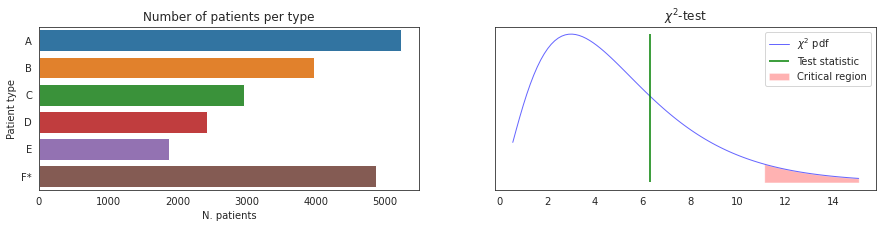

In [ ]:
visualize_patient_distr(df)

The left plot shows the observed number of patients of each type. As mentioned previously, we again see that the types with higher rates are more frequent than those with lower rates.

The plot on the right shows the results of the $\chi^2$-test with $N-1=5$ degrees of freedom with $\alpha=5\%$. We see that the null hypothesis that the observed values follow the expected distribution is not rejected (p-value $> 0.05$, the test statistic is not in the critical region). This is a good thing, it seems like the distribution of patient types is what we expect.


Lastly, one can analyze the length of stay distribution for each patient type. Those distributions are illustrated in the figure below. We see that the density (darker hue) is higher for low values and the distribution have a long tail. Note that the types with higher mean length-of-stay, ($e.g.$ $\frac{1}{\mu_B}=4$, $\frac{1}{\mu_C}=4.5$) have a distribution more spread out than those with lower mean length-of-stay ($\frac{1}{\mu_D}=1.4$).

Moreover, the empirical means and the theoritical means ($1/\mu_i$) are very close.

In [ ]:
def visualize_stay_distr(df):
    fig, ax = plt.subplots(1, 1, figsize=(15, 3))
    sns.histplot(
        data=df,
        x="Length of stay",
        y=df["Patient type"].map(int_to_letter),
        hue="Patient type",
        palette=["C0", "C1", "C2", "C3", "C4", "C5"],
        ax=ax,
        legend=False,
    )

    means = (
        df.groupby("Patient type")
        .agg({"Length of stay": "mean"})
        .rename(columns={"Length of stay": "Empirical mean"})
    )
    means.index = means.index.map(int_to_letter)
    means["Theoretical mean"] = mean_length_stay
    display(means)

,Empirical mean,Theoretical mean
Patient type,,
A,2.917681,2.9
B,3.951620,4.0
C,4.576476,4.5
D,1.377778,1.4
E,3.851353,3.9
F*,2.175174,2.2


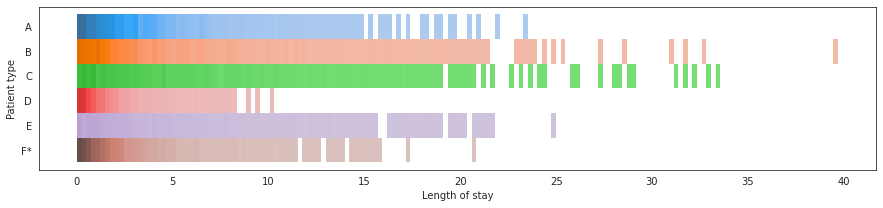

In [ ]:
visualize_stay_distr(df)

## Simulating hospital

**Simulating beds:**

The hospital beds are modelled as clocks, each bed contains the time when the bed will be empty, $i.e.$ available for a new patient.
Given a bed distribution, $i.e.$ an array of length $N=6$ containing the bed capacity for each ward $[c_A, c_B,c_C,c_D,c_E,c_{F^*}]$, the beds are modelled as a dictionary. A key is the ward type $k$ and the associated value is an array of length $c_k$.

At the start of the simulation, the beds are all initialized empty, $i.e.$ all of the clocks are set to $t=0$.

In [ ]:
def initialize_beds(bed_distribution):
    global ward_types
    # For each ward, the 'service units' are an array of beds.
    # Each 'bed' contains as value the global time until when it will be occupied.
    beds = {int(k): np.zeros((bed_distribution[k],)) for k in ward_types}
    return beds

**Simulating patients flow:**

The patient flow in the hospital is modelled by looping over the patients in the order of their arrival, update the state of the hospital accordingly and loging the decisions made and measures along the way. 

The main steps are as follows

 - Initialize the beds given the bed distribution and $t=0$.

 - Loop over the patients in the order of their arrival.

 - For each patient $i$:

     - Move forward in time to the patient's arrival time, $t = t_i$

     - Look if any bed is unocuppied in the patient's prefered ward $w_i$.

     - If it is the case, assign a bed to the patient. It is going to be occupied until $t$ + length-of-stay$_i$.

     - Otherwise, 

         - Increase the total amount of urgency points.

         - Randomly select an alternive ward $w_{alter}$ according to the probability distribution given in $prob\_relocate$

         - Look if any bed is unocuppied in $w_{atler}$. If it is the case, assign a bed. Otherwise, the patient is lost from the system.

     - Log the final allocated ward (or -1 for lost), the urgency points and the number of occupied beds in each ward

 - Return output dictionary containing the entire trace of logs of the simulation.


The simulation is first run and analyzed in the case where the bed distribution is $[50,40,30,20,20,0]$, $i.e.$ no bed is allocated to ward $F^{*}$. This will be our baseline that we will try to improve in the next part. 

In [ ]:
def simulate_hospital(bed_distribution, patients):
    global prob_relocate
    global ward_types
    global urgency_points
    urgency_allocations = np.zeros((6,))

    beds = initialize_beds(bed_distribution)
    t = 0
    urgency = 0
    trace = {}
    trace["Ward allocated"] = []
    trace["Urgency points"] = []
    trace.update(
        {
            k: []
            for k in [
                f"Ward {i} occupied beds" for i in ["A", "B", "C", "D", "E", "F*"]
            ]
        }
    )

    for i, patient in patients.iterrows():
        # Update clock and extract patient information
        t = patient["Arrival time"]
        ward = int(patient["Patient type"])

        # Beds available in prefered ward
        empty_beds_idx = np.argwhere(beds[ward] <= t).flatten()
        for w in ward_types:
            occupied_beds = len(beds[w]) - len(np.argwhere(beds[w] <= t).flatten())
            trace[f"Ward {int_to_letter[w]} occupied beds"].append(occupied_beds)

        # If at least one bed is available, place the patient in the first one
        if len(empty_beds_idx) > 0:
            beds[ward][empty_beds_idx[0]] = t + patient["Length of stay"]
            # Log
            trace["Ward allocated"].append(ward)
            trace[f"Ward {int_to_letter[ward]} occupied beds"][-1] += 1

        # Otherwise, all beds are occupied, relocate or lose patient
        else:
            urgency += urgency_points[ward]
            urgency_allocations[ward] += urgency_points[ward]

            # Draw alternative ward to relocate patient
            ward_alter = np.random.choice(ward_types, p=prob_relocate[ward, :])
            # Beds available in alternative ward
            empty_beds_idx = np.argwhere(beds[ward_alter] <= t).flatten()

            # If at least one bed is available, relocate the patient in the first one
            if len(empty_beds_idx) > 0:
                beds[ward_alter][empty_beds_idx[0]] = t + patient["Length of stay"]
                trace["Ward allocated"].append(ward_alter)
                trace[f"Ward {int_to_letter[ward_alter]} occupied beds"][-1] += 1

            # Otherwise, the patient is lost from the system
            else:
                trace["Ward allocated"].append(-1)

        trace["Urgency points"].append(urgency)

    # Add new columns to dataframe
    for k, v in trace.items():
        patients[k] = v

    output = {
        "Dataframe": patients,
        "Total urgency": urgency,
        "Bed distribution": bed_distribution,
        "Beds": beds,
        "Urgency allocations": urgency_allocations,
    }

    return output


output = simulate_hospital(bed_distribution=bed_capacity, patients=df)

## Performance measures

We can analyze the results of the simulation in many ways.

First, we can look at the number of occupied beds in each ward during the first week and during the entire 1 year-long simulation.
We see that all beds starts empty and that during the first week they all start to be occupied and the wards reached maximum capacity. Then, we observe that the capacity of the wards oscillate near the maximum capacity for the rest of the simulation. Sometimes the number of occupied beds is under the total number of beds for long period of time ($e.g.$ ward D). This is a good thing for patient going to such ward, as they will be alloacted their prefered ward. 

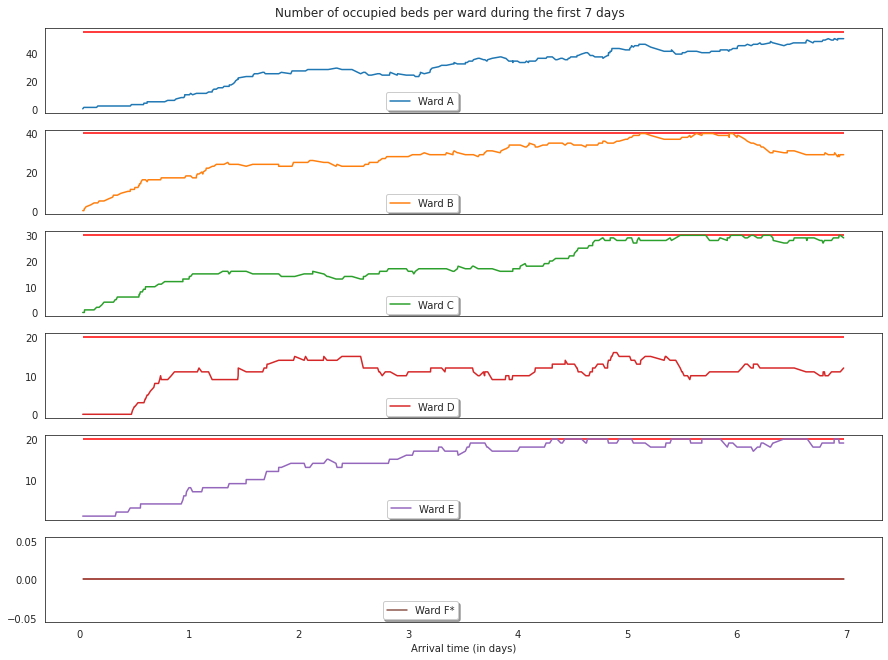

In [ ]:
def visualize_occupied_beds(output, days):
    df = output["Dataframe"][output["Dataframe"]["Arrival time"] < days]
    wards = ["A", "B", "C", "D", "E", "F*"]
    cols = [f"Ward {i} occupied beds" for i in wards]
    colors = ["C0", "C1", "C2", "C3", "C4", "C5"]
    t = df["Arrival time"]
    i = 0
    fig, axes = plt.subplots(6, 1, figsize=(15, 10), sharex=True)
    for i, col in enumerate(cols):
        ax = axes[i]
        ax.hlines(
            y=output["Bed distribution"][i], xmin=min(t), xmax=max(t), color="red"
        )
        ax.plot(t, df[col], c=colors[i], label=f"Ward {wards[i]}")
        ax.legend(bbox_to_anchor=(0.5, 0.30), fancybox=True, shadow=True)

    plt.subplots_adjust(top=0.95)
    plt.xlabel("Arrival time (in days)")
    plt.suptitle(f"Number of occupied beds per ward during the first {days} days")


visualize_occupied_beds(output, days=7)

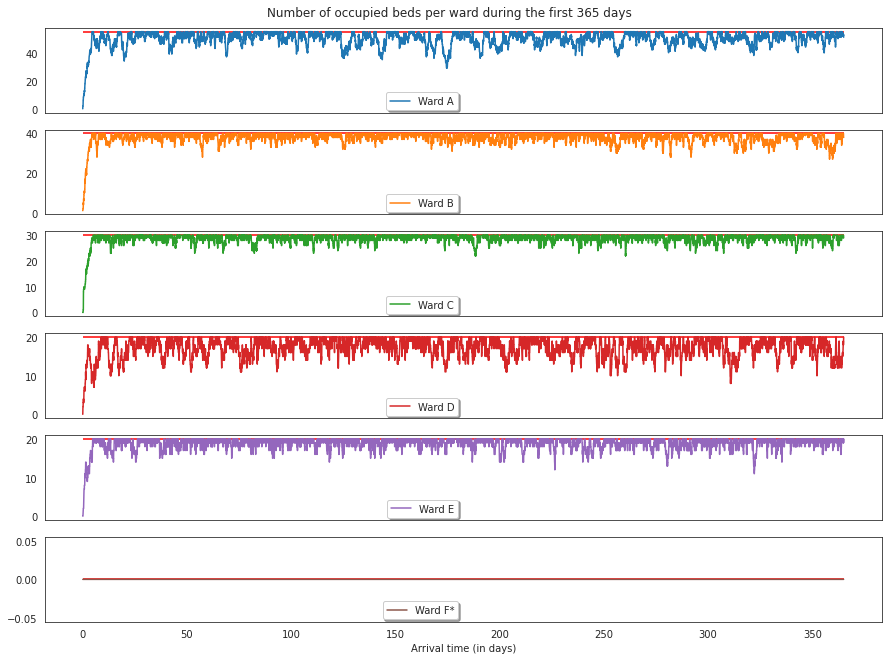

In [ ]:
visualize_occupied_beds(output, days=365)

The patient flow and the allocation of beds can be summarized and aggregated into a few values (using the convention to map the letters to integers $A=1, B=2, C=3, D=4, E=5, F^*=6$).

First, simply the total number of patients of each type that came to the hospital in a vector $T$ of size $6$, where $T_i$ is the total number of type $i$.

Secondly, the allocation of wards into a $6\times 6$ matrix $A$. Where the element $A_{i,j}$ is the number of patient of type $i$ that were allocated a bed in ward $j$. 

Thirdly, the number of lost patients for each type in a vector $L$ of size $6$, where $L_i$ is the number of lost patients of type $i$.

In [ ]:
def summarize_allocation(output):
    df = output["Dataframe"]
    allocation = np.zeros((6, 6))
    lost = np.zeros((6,))
    total = np.zeros((6,))
    for i in range(6):
        total[i] = len(df[(df["Patient type"] == i)])
        lost[i] = len(df[(df["Patient type"] == i) & (df["Ward allocated"] == -1)])
        for j in range(6):
            allocation[i, j] = len(
                df[(df["Patient type"] == i) & (df["Ward allocated"] == j)]
            )

    return total, allocation, lost


total, allocation, lost = summarize_allocation(output)
print("Total patients per ward:", total)
print("Table of allocation:\n", allocation)
print("Lost patients per ward:", lost)

Total patients per ward: [5301. 4031. 2924. 2385. 1862. 4742.]
Table of allocation:
 [[4582.   31.   39.   33.  214.    0.]
 [ 196. 2833.  275.  146.   98.    0.]
 [ 342.  164. 1556.  223.  184.    0.]
 [ 145.   78.    9. 1930.   60.    0.]
 [ 141.   63.  278.   71.  991.    0.]
 [ 803.  702.  506.  729.  502.    0.]]
Lost patients per ward: [ 402.  483.  455.  163.  318. 1500.]


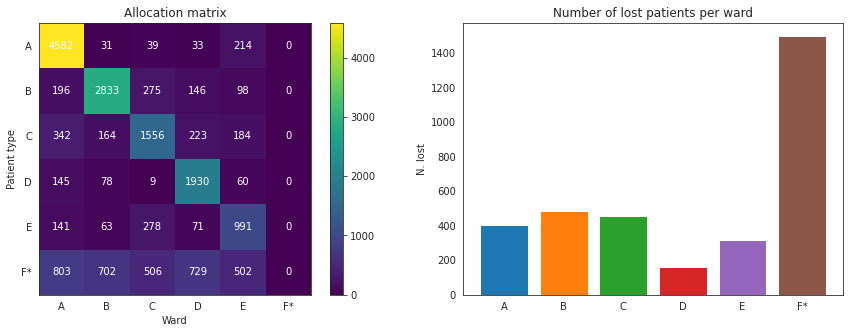

In [ ]:
def plot_allocation(allocation, lost):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    im = axes[0].imshow(allocation, cmap="viridis")
    for (j, i), label in np.ndenumerate(allocation):
        axes[0].text(i, j, int(label), ha="center", va="center", color="white")
    axes[0].set(title="Allocation matrix", xlabel="Ward", ylabel="Patient type")
    axes[0].set_xticks(
        np.arange(allocation.shape[0]), labels=["A", "B", "C", "D", "E", "F*"]
    )
    axes[0].set_yticks(
        np.arange(allocation.shape[1]), labels=["A", "B", "C", "D", "E", "F*"]
    )
    plt.colorbar(im, ax=axes[0])

    axes[1].bar(
        x=["A", "B", "C", "D", "E", "F*"],
        height=lost,
        color=["C0", "C1", "C2", "C3", "C4", "C5"],
    )
    axes[1].set(ylabel="N. lost", title="Number of lost patients per ward")
    plt.show()


plot_allocation(allocation, lost)

For the baseline case, where no new ward F* is created ($i.e.$ no bed allocated to F*), we observe as expected that the 6th column of the allocation matrix is empty. Moreover, we observe that 1500 patients of type F* out of around 4700 (nearly a third!) are lost from the system. All the others are distributed to the 5 other existing wards. This is bad. It means that, in the context where F* patients are those caused by a new epidemic, the hospital is not treating them. 

### Estimators

 - An estimate of the probability that all beds are occupied on arrival can be computed as such
$$
P(\text{All beds occupied in ward } i) = 1 - P(\text{Not all beds occupied in ward } i) = 1 - \frac{A_{i,i}}{Ti}
$$
Because the the probability that not all beds were occupied in ward $i$ upon arrival of a patient can be estimated by computing the number of patients assigned their prefered wards $A_{i,i}$, meaning that at least one bed was available, over the total amount of patient of that type $T_i$.



 - The expected number of admissions to ward $i$ is the sum of elements in column $i$ $\left(\sum_{k}A_{k,i}\right)$.


 - The expected number of relocations from ward $i$ is the sum of elements in row $i$ substracted by $A_{i,i}$ $\left(\sum_{k\neq i}A_{i,k}\right)$


 - The expected number of relocations to ward $i$ is the sum of elements in column $i$ substracted by $A_{i,i}$ $\left(\sum_{k\neq i}A_{k,i}\right)$

In [ ]:
def probability_all_occupied(output):
    total, allocation, lost = summarize_allocation(output)
    return 1 - np.diagonal(allocation) / total


def expected_admissions(output):
    total, allocation, lost = summarize_allocation(output)
    return np.sum(allocation, axis=0)


def expected_relocations_from(output):
    total, allocation, lost = summarize_allocation(output)
    return np.sum(allocation, axis=1) - np.diagonal(allocation)


def expected_relocations_to(output):
    total, allocation, lost = summarize_allocation(output)
    return np.sum(allocation, axis=0) - np.diagonal(allocation)

In [ ]:
probability_all_occupied(output)

array([0.11257645, 0.28758499, 0.45958742, 0.17511331, 0.47155768,
       1.        ])

In [ ]:
expected_admissions(output)

array([6304., 3881., 2680., 3184., 2077.,    0.])

In [ ]:
expected_relocations_from(output)

array([ 250.,  677.,  954.,  284.,  527., 3368.])

In [ ]:
expected_relocations_to(output)

array([1661., 1052., 1082., 1182., 1083.,    0.])

### Confidence intervals
Those estimators defined above are computed from one run of the simulation. But a better estimate would be to have confidence interval computed from multiple runs. 
Then, the variance of the estimators could be reduced using e.g. control variates.

As a reminder, the 1-$\alpha$% confidence interval for the mean of $n$ estimates, $\hat{\theta}_1,\dots,\hat{\theta}_2$:
$$
\bar{\theta} = \frac{\sum_{i=1}^n\hat{\theta}_i}{n}
$$
$$
S_{\theta}^2 = \frac{1}{n-1}\sum_{i=1}^n(\hat{\theta}_i^2 - \bar{\theta})
$$
$$
\left[\bar{\theta} + \frac{S_{\theta}}{\sqrt{n}} t_{\frac{\alpha}{2}}\: ; \: \bar{\theta} + \frac{S_{\theta}}{\sqrt{n}} t_{1-\frac{\alpha}{2}} \right]
$$
where $t$ is the quantile from the t-distribution with $n-1$ degrees of freedom.

In [ ]:
def confidence_interval(X, alpha=0.05):
    n = len(X)
    mean = np.mean(X)
    var = np.var(X, ddof=1)
    qt = stats.t.interval(1 - alpha, df=n - 1)
    conf = mean + np.array(qt) * np.sqrt(var) / np.sqrt(n)
    return conf

In [ ]:
def print_confidence_interval(
    N_sim,
    Nlosts=True,
    prob_occupied=True,
    total_urgency_conf=False,
    total_reloc_conf=False,
    bed_distribution=bed_capacity,
):
    losts = np.zeros((N_sim, 6))
    probs_occ = np.zeros((N_sim, 6))
    total_urgency = np.zeros((N_sim, 1))
    total_reloc = np.zeros((N_sim, 1))
    for i in range(N_sim):
        df_patients = initialize_patients(days=365)
        out = simulate_hospital(bed_distribution, patients=df_patients)
        _, _, losts[i, :] = summarize_allocation(out)
        probs_occ[i, :] = probability_all_occupied(out)
        total_urgency[i, :] = out["Total urgency"]
        total_reloc[i, :] = expected_relocations_from(out).sum()

    if Nlosts:
        for i, w in enumerate(["A", "B", "C", "D", "E", "F*"]):
            X = losts[:, i]
            conf = confidence_interval(X)
            print(
                "95% confidence interval for the N. losts patients of type {} is {}".format(
                    w, conf
                )
            )

    if prob_occupied:
        for i, w in enumerate(["A", "B", "C", "D", "E", "F*"]):
            X = probs_occ[:, i]
            conf = confidence_interval(X)
            print(
                "95% confidence interval for the probability all beds occupied of type {} is {}".format(
                    w, conf
                )
            )

    if total_urgency_conf:
        X = total_urgency[:, :]
        conf = confidence_interval(X)
        print(f"95% confidence interval for the total urgency is {conf}")

    if total_reloc_conf:
        X = total_reloc[:, :]
        conf = confidence_interval(X)
        print(f"95% confidence interval for the total relocations is {conf}")

In [ ]:
print_confidence_interval(
    N_sim=3,
    Nlosts=True,
    prob_occupied=True,
    total_urgency_conf=True,
    total_reloc_conf=True,
    bed_distribution=bed_capacity,
)

95% confidence interval for the N. losts patients of type A is [261.26251801 456.73748199]
95% confidence interval for the N. losts patients of type B is [399.89333613 596.77333054]
95% confidence interval for the N. losts patients of type C is [366.5705543  452.09611237]
95% confidence interval for the N. losts patients of type D is [101.64002327 220.35997673]
95% confidence interval for the N. losts patients of type E is [256.80782634 405.19217366]
95% confidence interval for the N. losts patients of type F* is [1247.03322304 1629.63344362]
95% confidence interval for the probability all beds occupied of type A is [0.08748436 0.1460892 ]
95% confidence interval for the probability all beds occupied of type B is [0.27618948 0.32779146]
95% confidence interval for the probability all beds occupied of type C is [0.41950494 0.48170254]
95% confidence interval for the probability all beds occupied of type D is [0.16201241 0.22455865]
95% confidence interval for the probability all beds oc

The current bed capacity is challenged by the bed demand and results in a significantly high number of urgency points and relocations. The probability that the beds are occupied upon arrival seems higest among wards C and E as influenced by their long mean length of stay.

# New ward $F^*$
A new ward $F^*$ will be now be introduced in the system. This new ward will receive beds from the other wards. The optimal bed distribution with this new ward introduced, will be explored. The optimal bed distribution will be defined as the bed distribution where a minimal number of the current bed resources to the new ward is allocated. Such a bed distribution should ensure that at least 95% of the type $F^*$ patients are hospitalized in ward $F^*$. Furthermore, the "urgency points" from Table 1 should (and will) be considered when balancing the solution.

## Trials and errors
First we'll try and lower the urgency points by simulating different permutations of bed capacities. So capacities will be distributed in favour of the following heuristics:

 - Problem given capacity (baseline)

 - High arrival wards
 
 - High mean length-of-stay

 - Focus on $F^*$

 - Spread evenly
 
 - **(Heuristic Approach)** Taking bed from those with low probability of all beds occupied
 


In [ ]:
def trial_and_error():

    results = []
    o = simulate_hospital(bed_distribution=bed_capacity, patients=df)
    results += [
        (
            "base",
            o["Total urgency"],
            expected_relocations_from(o).sum(),
            summarize_allocation(o),
        )
    ]

    bed_cap = [60, 45, 5, 5, 5, 45]
    o = simulate_hospital(bed_distribution=bed_cap, patients=df)
    results += [
        (
            "More beds to high arrival",
            o["Total urgency"],
            expected_relocations_from(o).sum(),
            summarize_allocation(o),
        )
    ]

    bed_cap = [20, 45, 45, 20, 35, 0]
    o = simulate_hospital(bed_distribution=bed_cap, patients=df)
    results += [
        (
            "More beds to patients that stay long",
            o["Total urgency"],
            expected_relocations_from(o).sum(),
            summarize_allocation(o),
        )
    ]

    bed_cap = [50, 40, 20, 40, 5, 10]
    o = simulate_hospital(bed_distribution=bed_cap, patients=df)
    results += [
        (
            "More beds to high urgency (A and D)",
            o["Total urgency"],
            expected_relocations_from(o).sum(),
            summarize_allocation(o),
        )
    ]

    bed_cap = [35, 30, 20, 10, 10, 60]
    o = simulate_hospital(bed_distribution=bed_cap, patients=df)
    results += [
        (
            "Primary F*",
            o["Total urgency"],
            expected_relocations_from(o).sum(),
            summarize_allocation(o),
        )
    ]

    bed_cap = [30, 30, 30, 30, 25, 20]
    o = simulate_hospital(bed_distribution=bed_cap, patients=df)
    results += [
        (
            "Even out",
            o["Total urgency"],
            expected_relocations_from(o).sum(),
            summarize_allocation(o),
        )
    ]

    return pd.DataFrame(
        results,
        columns=["Title", "Total urgency points", "Total relocations", "Summary"],
    )


tae_df = trial_and_error()

Manually tweaking the bed distribution with the same set of patients did not result in less urgency points being spent. However, it did give some insights into how the configurations may impact the patient flow. For example having more beds in high urgency wards reduces the number of lost patients.

## Heuristic approach

We continue the trial and error approach by considering the base bed distribution: \[55, 40, 30, 20, 20, 0\] and setting the number of beds in ward $F$ to 0 initially. In each iteration we get a new bed distribution. This is done by taking a bed from the ward with lowest probability of occupied beds and putting it in ward $F$. We never take beds from ward $F$. We run a simulation with the new bed distribution and check whether the criteria of 95% of patients $F$ are hospitalised in ward $F$. When this happens, we have found the optimal bed distribution and exit the loop. It is also possible to take a bed from the ward with lowest urgency as suggested in the assignment description but this would result in the final distribution of beds to be highly non-uniform as there is a risk of continuously taking beds from wards with a very high initial urgency.

In [ ]:
def are_enough_patients_located_to_primary_ward(
    proposal_sim, ward_and_patient_type, min_fraction=0.95
):
    located_in_primary_ward = expected_admissions(proposal_sim)[ward_and_patient_type]
    total_patients_of_type = np.sum(
        proposal_sim["Dataframe"]["Patient type"] == ward_and_patient_type
    )
    return (
        total_patients_of_type == 0
        or located_in_primary_ward / float(total_patients_of_type) >= min_fraction
    )


def get_new_bed_distribution(bed_distr, sim):
    global ward_types

    # ward_from = np.argmin(sim['Urgency allocations'][:-1], axis=0) ### pick bed from ward with lowest urgency
    ward_from = np.argmin(
        probability_all_occupied(sim)[:-1]
    )  ### pick bed from ward with lowest occupied prob

    ward_to = ward_types[-1]  # only re-allocate to ward F*

    proposal_distr = bed_distr.copy()
    proposal_distr[ward_from] -= 1
    proposal_distr[ward_to] += 1

    return proposal_distr


def optimize_bed_distributions_heuristic(bed_distr, N_iterations):
    bed_distrs = np.empty((N_iterations, 6))

    df = initialize_patients(days=365)
    sim = simulate_hospital(bed_distr, df)

    for i in range(N_iterations):

        # get proposal
        bed_distr = get_new_bed_distribution(bed_distr, sim)

        sim = simulate_hospital(bed_distr, df)

        print(f"iteration {i + 1}/{N_iterations}, bed distr {bed_distr} ")

        bed_distrs[i] = bed_distr

        if are_enough_patients_located_to_primary_ward(sim, 5):
            bed_distrs = bed_distrs[: i + 1]
            break

    return bed_distrs

In [ ]:
trial_and_error_heuristic_prob_result = optimize_bed_distributions_heuristic(
    bed_capacity, N_iterations=50
)

iteration 1/50, bed distr [54, 40, 30, 20, 20, 1] 
iteration 2/50, bed distr [53, 40, 30, 20, 20, 2] 
iteration 3/50, bed distr [52, 40, 30, 20, 20, 3] 
iteration 4/50, bed distr [51, 40, 30, 20, 20, 4] 
iteration 5/50, bed distr [50, 40, 30, 20, 20, 5] 
iteration 6/50, bed distr [50, 40, 30, 19, 20, 6] 
iteration 7/50, bed distr [49, 40, 30, 19, 20, 7] 
iteration 8/50, bed distr [49, 40, 30, 18, 20, 8] 
iteration 9/50, bed distr [48, 40, 30, 18, 20, 9] 
iteration 10/50, bed distr [47, 40, 30, 18, 20, 10] 
iteration 11/50, bed distr [47, 40, 30, 17, 20, 11] 
iteration 12/50, bed distr [46, 40, 30, 17, 20, 12] 
iteration 13/50, bed distr [45, 40, 30, 17, 20, 13] 
iteration 14/50, bed distr [44, 40, 30, 17, 20, 14] 
iteration 15/50, bed distr [44, 40, 30, 16, 20, 15] 
iteration 16/50, bed distr [44, 40, 30, 15, 20, 16] 
iteration 17/50, bed distr [43, 40, 30, 15, 20, 17] 
iteration 18/50, bed distr [42, 40, 30, 15, 20, 18] 
iteration 19/50, bed distr [41, 40, 30, 15, 20, 19] 
iteration 2

We see that the rule is satisfied when $F^*$ has 35 beds. However, it is unclear what the probability is, that the rule is satistified, when $F^*$ has 35 beds.

In [ ]:
heuristic_beds = trial_and_error_heuristic_prob_result[-1].astype(int)

It will now be tested how often the rule is satisfied when ward $F^*$ has 34, 35 and 36 beds. We will run the simulation 100 times where $F^*$ has 34 beds. This will also be done where $F^*$ has 35 and 36 beds respectively.

In [ ]:
def test_rule_satisfied(bed_distr, N_iterations=100):
    count = 0
    for _ in range(N_iterations):
        df_patient = initialize_patients(days=365)
        out = simulate_hospital(bed_distr, df_patient)
        probs = probability_all_occupied(out)
        if probs[-1] < 0.05:
            count += 1

    print(
        "bed distr: {} satisfied rule {}/{} times.".format(
            bed_distr, count, N_iterations
        )
    )

In [ ]:
bed_distr_34 = [19, 40, 30, 20, 20, 34]
test_rule_satisfied(bed_distr_34)

bed distr: [19, 40, 30, 20, 20, 34] satisfied rule 67/100 times.


In [ ]:
bed_distr_35 = [19, 40, 30, 20, 20, 35]
test_rule_satisfied(bed_distr_35)

bed distr: [19, 40, 30, 20, 20, 35] satisfied rule 97/100 times.


In [ ]:
bed_distr_36 = [19, 40, 30, 20, 20, 36]
test_rule_satisfied(bed_distr_36)

bed distr: [19, 40, 30, 20, 20, 36] satisfied rule 99/100 times.


In the next section, MCMC simulated annealing will be used to determine how many beds ward $A, B, C, D, E$ will respectively allocate to ward $F^*$. Since, $F^*$ has to satisfy the rule, we can already choose the number of beds allocated to ward $F^*$. This will lead to a reduced state space the MCMC Simulated annealing has to explore. In the simulation above, it can be seen that using 36 beds, the rule is satisfied 99 out of 100 times, which is why 36 beds will be chosen to be allocated to ward $F^*$. Hence, it is the minimum number of beds needed to be re-allocated to ward $F^*$ in order to satisfy the criteria "often enough".

## MCMC Simulated annealing
Simulated annealing will now be used to find the optimal bed distributions between the wards. We want to find a bed distribution that simultaneously allocates a minimal number of beds to the new ward while ensuring that at least 95% of the type $F^*$ patients are hospitalized in Ward $F^*$ and has the lowest total urgency cost. Those tree criteria can be summarized in this cost function that we want to minimize. 
$$ 
\text{cost} = (\lambda_1 \times \text{urgency}) + (\lambda_2 \times \text{N.beds in F*}) + (\lambda_3 \times \mathbb{I}(\text{Not 95\% F* addmitted in F*}))
$$
with $\lambda_1$, $\lambda_2$ and $\lambda_3$ hyper-parameter weights that define how we prioritize each criterion (NB: $\mathbb{I}(x)$ equals 1 if $x$ is satisfied, 0 otherwise). 


Using trial and error, it was found that 36 beds should be re-allocated to ward $F^*$  in order to satisfy the 95% criterion. The cost function can thus be simplified to only take into account the urgency. Indeed, the minimal number of beds in F* that ensures the 95% rule has been found and is now fixed. The cost is now defined as the 'average urgency',

$$ 
\text{cost} = c \cdot \text{urgency}
$$

The cost function is rescaled using the constant $c$, such that the cost function has a value between $[0;100]$. The rescaling leads to temperatures in the range $[0;1]$, that are more appropriate to work with. A proposal bed distribution is computed by re-arranging the bed distribution between all wards except ward F*. One bed is moved from one ward to another ward. The maximum number of beds in a ward is the initial bed distribution presented in the assignment statement. 

All in all, the MCMC algorithm is re-balancing the beds in the 5 original wards in order to minimize the total urgency points, knowing that the hospital is already allocating 36 fixed beds to ward F*.

In order to do simulated annealing, a temperature function has to be defined. Several different temperature functions were inspected, as shown below.

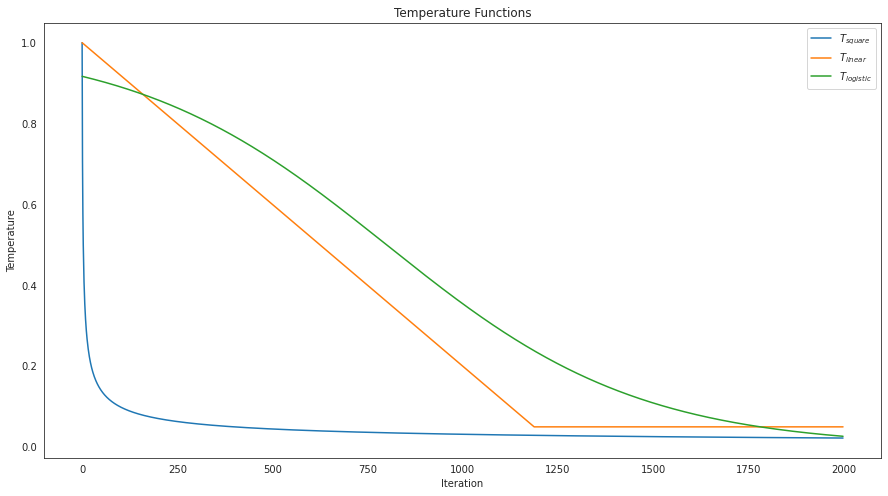

In [ ]:
# Temperature functions


def T_square(k, L0=1):
    return L0 / np.sqrt(1 + k)


def T_linear(k, L0=1, beta=8e-4, minimum=5e-2):
    return np.clip(L0 - beta * k, minimum, None)


def T_logistic(k, L0=1, k0=800, growth_rate=-0.003):
    return L0 / (1 + np.exp(-growth_rate * (k - k0)))


def T_constant(k, L0=0.1):
    return L0


def plot_temperature_functions():
    fig, ax = plt.subplots(figsize=(15, 8))

    ax.set(title="Temperature Functions", xlabel="Iteration", ylabel="Temperature")

    iterations = np.arange(2000)
    ax.plot(iterations, T_square(iterations), label="$T_{square}$")
    ax.plot(iterations, T_linear(iterations), label="$T_{linear}$")
    ax.plot(iterations, T_logistic(iterations), label="$T_{logistic}$")
    # ax.plot(iterations, T_constant(iterations), label='$T_{constant}$')

    ax.legend()
    plt.plot()


plot_temperature_functions()

Notice, the squared temperature function is very step. Hence, it is a poor choice, since the sample space has to be explored more. The linear temperature function shown above, will be used, since the temperature is decreasing slowly. The logistic temperature function appears to be a good temperature candidate as well.

In [ ]:
def optimize_bed_distributions(
    initial_bed_func,
    T_func,
    bed_capacity,
    N_iterations,
    reinit_patients=True,
    strict_requirements=False,
):
    def cost(
        sim,
        urgency_penalty=1,
        ward_Fstar_bed_penalty=0,
        at_least_95_in_ward_Fstar_penalty=0,
    ):
        total_penalty = (
            urgency_penalty + ward_Fstar_bed_penalty + at_least_95_in_ward_Fstar_penalty
        )

        # compute the average total urgency per patient. Value between [0, 1]
        patients = sim["Dataframe"]
        avg_urgency_per_patient = sim["Total urgency"] / patients.shape[0]
        cost1 = urgency_penalty * avg_urgency_per_patient / np.mean(urgency_points)

        # compute fraction of beds allocated to F*. Value between [0,1]
        beds = sim["Beds"]
        bed_fraction = np.size(beds[5]) / np.sum(
            [np.size(beds[ward_type]) for ward_type in ward_types]
        )
        cost2 = ward_Fstar_bed_penalty * bed_fraction

        # penalty if criteria not met,, Value 0 or 1
        enough = are_enough_patients_located_to_primary_ward(sim, 5)  # 5 := F*
        cost3 = (1 - enough) * at_least_95_in_ward_Fstar_penalty

        # normalize the cost, so it is always between [0,1]
        normalized_cost = (cost1 + cost2 + cost3) / total_penalty

        c = 100  # scale so the cost is [0;100]. Then we don't have to scale the temperature functions.

        return normalized_cost * c

    def get_proposal_bed_distribution(bed_distr):
        global ward_types
        global bed_capacity

        wards_considered = ward_types[:-1]

        wards_from = np.array(
            [ward for ward in wards_considered if bed_distr[ward] > 0]
        )
        ward_from = np.random.choice(wards_from)

        wards_to = np.array(
            [
                ward
                for ward in wards_considered
                if ward != ward_from and bed_distr[ward] + 1 <= bed_capacity[ward]
            ]
        )
        ward_to = np.random.choice(wards_to)

        proposal_distr = bed_distr.copy()
        proposal_distr[ward_from] -= 1
        proposal_distr[ward_to] += 1

        return proposal_distr

    costs = np.empty(N_iterations)
    bed_distrs = np.empty((N_iterations, 6))

    total_bed_capacity = np.sum(bed_capacity)
    bed_distr = initial_bed_func()

    df = initialize_patients(days=365)
    sim = simulate_hospital(bed_distr, df)

    for i in range(N_iterations):
        print(f"iteration {i + 1}/{N_iterations}")

        # get proposal
        proposal_bed_distr = get_proposal_bed_distribution(bed_distr)

        # Decide on whether we should create a new sample of patients
        if reinit_patients:
            df = initialize_patients(days=365)

        # simulate using proposal
        proposal_sim = simulate_hospital(proposal_bed_distr, df.copy())

        if strict_requirements:
            # Ensure that at least 95% of the type F* patients are hospitalized in Ward F∗
            if not are_enough_patients_located_to_primary_ward(
                proposal_sim, 5
            ):  # 5 := F*
                continue

        proposal_cost = cost(proposal_sim)
        current_cost = cost(sim)

        # Accept proposal
        if proposal_cost < current_cost:
            sim = proposal_sim
            bed_distr = proposal_bed_distr
            current_cost = proposal_cost

        # Accept proposal by a probability
        else:
            p = np.exp(-(proposal_cost - current_cost) / T_func(i))
            if p >= np.random.uniform():
                sim = proposal_sim
                bed_distr = proposal_bed_distr
                current_cost = proposal_cost

        costs[i] = current_cost
        bed_distrs[i] = bed_distr

    # store result
    output = {"Costs": costs, "Bed distributions": bed_distrs}

    return output

The simulated annealing algorithm will run for 1200 iterations. The temperature is the linear temperature function depicted above. In the initial bed distribution, 36 beds are re-allocated from ward A to ward F*. 

In [ ]:
# run the simulation


def get_initial_beds():
    def move(bed_capacity, ward_from, ward_to, amount):
        assert bed_capacity[ward_from] >= amount

        bed_capacity[ward_from] -= amount
        bed_capacity[ward_to] += amount

    initial_beds = np.copy(bed_capacity)
    move(initial_beds, 0, 5, 36)

    return initial_beds


def T(k):
    return T_linear(k)


# simulated_annealing_result = optimize_bed_distributions(get_initial_beds, T, bed_capacity, N_iterations=800, strict_requirements=False)

Let's load the result obtained from a single run and visualize it.

In [ ]:
bed_distrs = np.load("Data/result3_bed_distrs.npy").astype(np.int32)
costs = np.load("Data/result3_costs.npy")
patients = np.load("Data/result3_patients.npy")

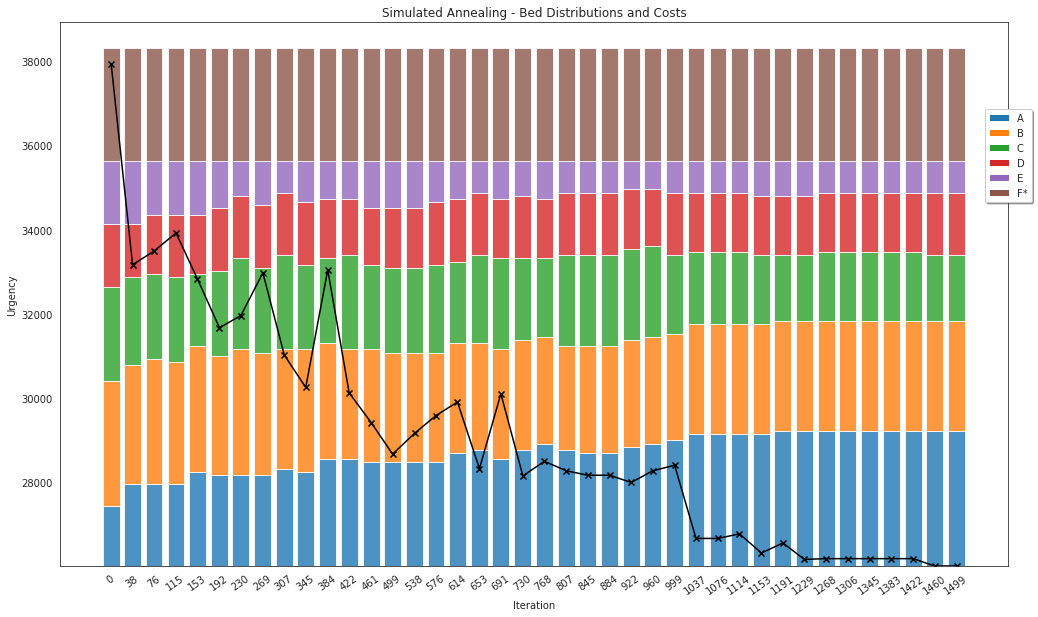

In [ ]:
def plot_bed_distribution_optimization(
    bed_distrs, costs, patients=None, max_bins=40, save_fig=False
):
    N_iterations = np.size(costs)
    N_bins = min(max_bins, N_iterations)

    iterations = np.linspace(0, N_iterations - 1, N_bins, dtype=np.int32)

    fig, ax = plt.subplots(figsize=(17, 10))

    # compute the urgencies from the cost and number of patients
    if patients is not None:
        c = 100
        urgencies = costs * patients * np.mean(urgency_points) / c
        graph = urgencies
        ylabel = "Urgency"

    # or just use the cost if the number of patients are not available
    else:
        graph = costs
        ylabel = "Cost"

    # set titles + ticks
    ax.set(
        title="Simulated Annealing - Bed Distributions and Costs",
        xlabel="Iteration",
        ylabel=ylabel,
    )
    ax.set_xticks(iterations)
    plt.xticks(rotation=35)

    # plot bed distributions
    distr_height = np.max(graph) - np.min(graph)
    distr_width = N_iterations / N_bins * 0.8

    total_beds = np.sum(bed_distrs[0])

    colors = ["C0", "C1", "C2", "C3", "C4", "C5"]

    for i in iterations:
        distr = bed_distrs[i]
        yOffset = np.min(graph)
        for j, bet in enumerate(distr):
            h = bet / total_beds * distr_height
            label = int_to_letter[j] if i == np.min(iterations) else None
            ax.bar(
                i + 1,
                h,
                width=distr_width,
                bottom=yOffset,
                color=colors[j],
                alpha=0.8,
                label=label,
            )
            yOffset += h

    # plot costs
    graph_color = "black"

    ax.scatter(1 + iterations, graph[iterations], color=graph_color, marker="x")
    # ax.plot(1+np.arange(N_iterations), graph, color=graph_color)
    ax.plot(1 + iterations, graph[iterations], color=graph_color)

    # legend
    current_handles, current_labels = plt.gca().get_legend_handles_labels()
    leg = ax.legend(
        current_handles,
        ["A", "B", "C", "D", "E", "F*"],
        loc="upper center",
        bbox_to_anchor=(1.0, 0.85),
        ncol=1,
        fancybox=True,
        shadow=True,
    )

    for lh in leg.legendHandles:
        lh.set_alpha(1)

    # save or plot
    if save_fig:
        plt.savefig("optimization.png")
    else:
        plt.show()


plot_bed_distribution_optimization(bed_distrs, costs, patients)

40 of the 1500 iterations has been plotted above. Notice, the urgency (and the cost) are not strictly decreasing. Hence, worse proposal bed distribution are accepted as well, which leads to the sample space being explored more. Hence, getting stuck at local minimums is less likely.

In [ ]:
def summarize_simulated_annealing(costs, bed_distrs, patients):

    # print the final bed distribution
    for i in range(6):
        print(f"{int_to_letter[i]}: {bed_distrs[-1, i]} beds")

    c = 100
    total_urgency = costs[-1] * patients[-1] * np.mean(urgency_points) / c
    print(f"Total urgency: {total_urgency:.2f}")


summarize_simulated_annealing(costs, bed_distrs, patients)

A: 43 beds
B: 35 beds
C: 21 beds
D: 20 beds
E: 10 beds
F*: 36 beds
Total urgency: 26019.00


The optimal bed distribution and total urgency of this solution is shown above. Notice, the bed distribution of ward E has decreased from $20$ to $10$ beds. This is not surprising, since the urgency points and the arrival rate are relatively low. Notice, ward B has same the urgency as ward E. However, the arrival rate of ward B is larger than ward E. Furthermore, the mean stay is comparable between these two wards. In the optimal solution, the bed capacity in ward B is decreased by only $5$ beds to a total of $35$ beds. However, the bed capacity in ward E is decreased by $10$ beds to $10$ beds. Considering the difference in arrival time, such a deficit is not surprising. 

Compared to the initial bed distribution in the simulation, the final number of beds in ward A has increased from $19$ beds to $43$ beds. The urgency and arrival rate is large and the mean stay is average for ward A. Hence, it is not surprising the final number of beds allocated to ward A has increased as well.

The bed distribution of ward B has decreased from $40$ beds to $35$ beds. Hence, ward B has fewer beds than ward A. This is not surprising, since the urgency and arrival are lower than those in ward A. The mean state is larger for ward B, yet it does not appear to outweight the two other variables.

The simulation ran multiple times, either using a fixed patient population or creating a new patient population for each iteration of the simulation. The optimal bed distribution found by each of these two approaches were different. It is plausible that this is caused to "over-fitting", when using the same patient population in all the simulation iterations.

## Comparing solutions
The urgency table and the expected number of relocated patients will now be used to assess the distribution of beds.


In [ ]:
# best found results
optimal_beds = bed_distrs[-1]
optimal_costs = costs[-1]
optimal_patients = patients[-1]

In [ ]:
for i, row in tae_df.iterrows():
    print(
        "Total urgency for trial and error: {} is {}".format(
            i, row["Total urgency points"]
        )
    )
    print(
        "Total relocations for trial and error: {} is {}".format(
            i, row["Total relocations"]
        )
    )
    print()

Total urgency for trial and error: 0 is 21666
Total relocations for trial and error: 0 is 5982.0

Total urgency for trial and error: 1 is 38113
Total relocations for trial and error: 1 is 3182.0

Total urgency for trial and error: 2 is 35137
Total relocations for trial and error: 2 is 7083.0

Total urgency for trial and error: 3 is 25131
Total relocations for trial and error: 3 is 4586.0

Total urgency for trial and error: 4 is 46406
Total relocations for trial and error: 4 is 3046.0

Total urgency for trial and error: 5 is 32828
Total relocations for trial and error: 5 is 4551.0



In [ ]:
output_heuristic = simulate_hospital(bed_distribution=heuristic_beds, patients=df)

print("Total urgency for heuristic method:", output_heuristic["Total urgency"])
print(
    "Total relocations for heuristic method",
    expected_relocations_from(output_heuristic).sum(),
)

NameError: name 'heuristic_beds' is not defined

In [ ]:
output_simulated_annealing = simulate_hospital(
    bed_distribution=optimal_beds, patients=df
)

print(
    "Total urgency for simulated annealing method:",
    output_simulated_annealing["Total urgency"],
)
print(
    "Total relocations for simulated annealing method",
    expected_relocations_from(output_simulated_annealing).sum(),
)

[10570.  7610.  3776.  2190.  6555.     0.]
Total urgency for simulated annealing method: 30701
Total relocations for simulated annealing method 3013.0
[9590. 7670. 3470. 2450. 6525.    0.]
Total urgency for simulated annealing method: 29705
Total relocations for simulated annealing method 2950.0


In [ ]:
""" Heuristic """
print_confidence_interval(
    N_sim=10,
    Nlosts=False,
    prob_occupied=False,
    total_urgency_conf=True,
    bed_distribution=heuristic_beds,
)

95% confidence interval for the total urgency is [35234.83440335 36054.56559665]


In [ ]:
""" Simulated annealing """
print_confidence_interval(
    N_sim=10,
    Nlosts=False,
    prob_occupied=False,
    total_urgency_conf=True,
    bed_distribution=optimal_beds,
)

95% confidence interval for the total urgency is [27921.10375055 29601.09624945]
95% confidence interval for the total urgency is [27471.02884419 28730.57115581]


In [ ]:
""" Heuristic """
print_confidence_interval(
    N_sim=10,
    Nlosts=False,
    prob_occupied=False,
    total_reloc_conf=True,
    bed_distribution=heuristic_beds,
)

95% confidence interval for the total relocations is [3276.63741977 3396.76258023]
95% confidence interval for the total relocations is [3220.53997404 3392.06002596]


In [ ]:
""" Simulated annealing """
print_confidence_interval(
    N_sim=10,
    Nlosts=False,
    prob_occupied=False,
    total_reloc_conf=True,
    bed_distribution=optimal_beds,
)

95% confidence interval for the total relocations is [2859.00997539 2955.99002461]
95% confidence interval for the total relocations is [2851.3825004 2980.4174996]


It can be seen that values for total urgency and total relocations for each method obtained in this specific run falls within the confidence intervals. Furthermore, as expected we see that the confidence interval limits for both the urgency and relocations are lower for the simulated annealing case compared to the heuristic approach.

In [ ]:
print_confidence_interval(
    N_sim=10,
    Nlosts=True,
    prob_occupied=True,
    total_urgency_conf=True,
    bed_distribution=optimal_beds,
)

95% confidence interval for the N. losts patients of type A is [ 949.81169398 1050.58830602]
95% confidence interval for the N. losts patients of type B is [636.96996189 706.63003811]
95% confidence interval for the N. losts patients of type C is [664.51310706 722.88689294]
95% confidence interval for the N. losts patients of type D is [ 97.82876775 123.97123225]
95% confidence interval for the N. losts patients of type E is [594.33206932 635.06793068]
95% confidence interval for the N. losts patients of type F* is [46.58909139 64.41090861]
95% confidence interval for the probability all beds occupied of type A is [0.24686852 0.26623841]
95% confidence interval for the probability all beds occupied of type B is [0.31396095 0.33654105]
95% confidence interval for the probability all beds occupied of type C is [0.58278187 0.60224353]
95% confidence interval for the probability all beds occupied of type D is [0.08722697 0.10268588]
95% confidence interval for the probability all beds occu

When compared to the solution from the heuristic approach we see both the total number of relocations and total number of urgency points decreasing for the optimal bed distribution found via simulated annealing. There are some bed distributions via the trial and error approach that result in lower urgencies but this comes at the cost of higher relocations. Therefore, the solution found via simulated annealing is most optimal.

# Sensitivity analysis

We use sensitivity analysis to determine how different values of an independent variable affect a particular dependent variable under the given assumptions. The sensitivity analysis secures how various sources of uncertainty in the hospital model contribute to the model's overall uncertainty. This technique is used within specific boundaries that depend on one or more input variables. We will determine the hospital model sensitivity to the length-of-stay distribution, bed distribution, and the total number of beds in the hospital.

## Length-of-stay distribution

Test the system’s sensitivity to the length-of-stay distribution by replacing the exponential
distribution with the log-normal distribution. Test the new distribution by gradually increasing the variance (e.g. $\sigma_{i}=2/\mu_{i}^2, 3/\mu_{i}^2, 4/\mu_{i}^2$).

In [ ]:
def mu_lognorm(mu, sigma):
    return np.exp(mu + (sigma**2 / 2))


def sigma_lognorm(mu, sigma):
    var = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    return np.sqrt(var)

In [ ]:
def initialize_patients_log_normal(days, sigma_numerator=2):
    global patient_types
    global arrival_per_day
    global mean_length_stay

    dic = {"Patient type": [], "Arrival time": [], "Length of stay": []}
    inter_arrival_clocks = np.array(
        [np.random.exponential(scale=1 / arrival_per_day[i]) for i in patient_types]
    )

    # Do 1 fictitious day at the beginning of the simulation to eliminate initialization artifact
    t = -1
    while t < days:
        # Select next patient (one with shortest time to come to hospital)
        idx = np.argmin(inter_arrival_clocks)
        delta = inter_arrival_clocks[idx]

        # Update time and clocks
        t += delta
        inter_arrival_clocks -= delta

        # Register patient
        if t > 0 and t < days:
            dic["Patient type"].append(idx)
            dic["Arrival time"].append(t)
            dic["Length of stay"].append(
                np.random.lognormal(
                    sigma=np.sqrt(sigma_numerator * mean_length_stay[idx] ** 2)
                )
            )  # scale=mean_length_stay[idx]

        # Re-initialize next patient of that type
        inter_arrival_clocks[idx] = np.random.exponential(
            scale=1 / arrival_per_day[idx]
        )

    data = pd.DataFrame(dic)
    data["Patient type"] = pd.Categorical(data["Patient type"])
    return data

Simulating with optimal bed distribution and exponential length of stay


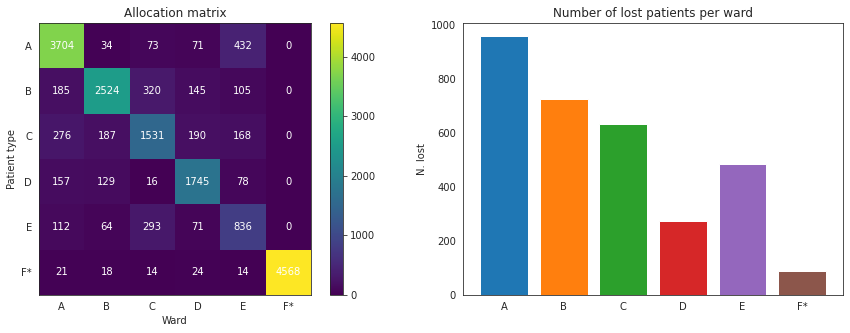

In [ ]:
# normal with optimal
print("Simulating with optimal bed distribution and exponential length of stay")
o = simulate_hospital(
    bed_distribution=optimal_beds, patients=initialize_patients(days=365)
)
total, allocation, lost = summarize_allocation(o)
plot_allocation(allocation, lost)

Simulating with optimal bed distribution and log-normal length of stay


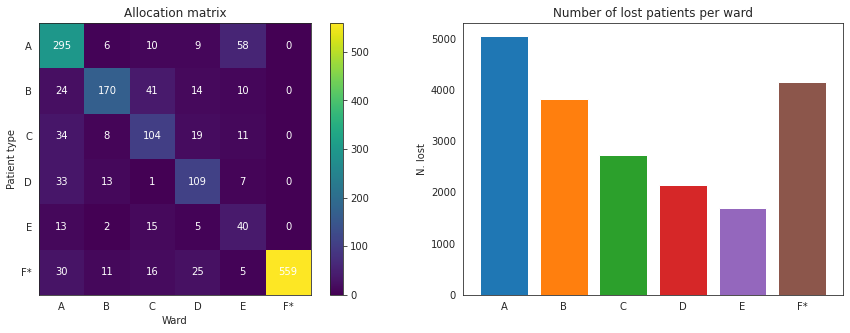

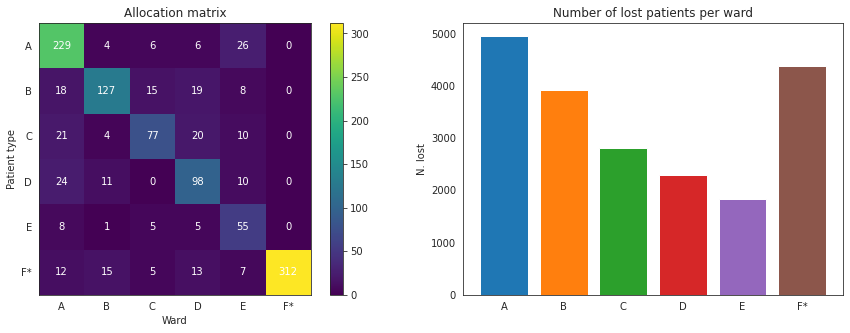

In [ ]:
print("Simulating with optimal bed distribution and log-normal length of stay")

# log normal with sigma numerator 2
patients_log_normal_2 = initialize_patients_log_normal(days=365, sigma_numerator=2)
o_log_normal = simulate_hospital(
    bed_distribution=optimal_beds, patients=patients_log_normal_2
)
total, allocation, lost = summarize_allocation(o_log_normal)
plot_allocation(allocation, lost)

# log normal with sigma numerator 4
patients_log_normal_4 = initialize_patients_log_normal(days=365, sigma_numerator=4)
o_log_normal = simulate_hospital(
    bed_distribution=optimal_beds, patients=patients_log_normal_4
)
total, allocation, lost = summarize_allocation(o_log_normal)
plot_allocation(allocation, lost)

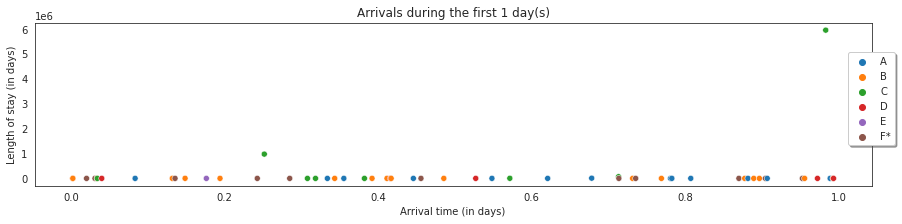

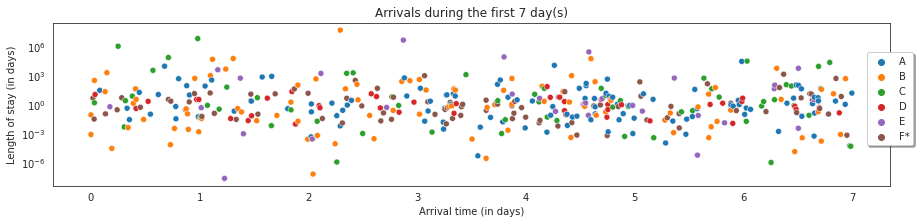

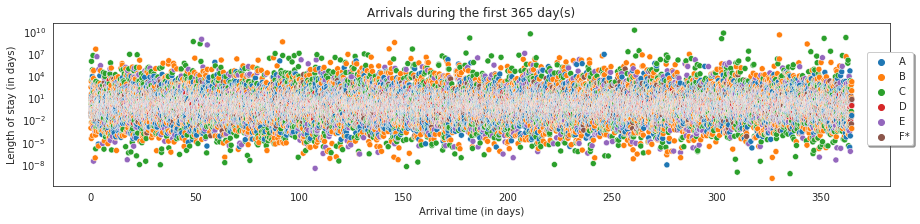

In [ ]:
visualize_arrivals(patients_log_normal_2, days=1)
visualize_arrivals(patients_log_normal_2, days=7, log=True)
visualize_arrivals(patients_log_normal_2, days=365, log=True)

Using the log-normal beds gets occupied for a lot longer resulting in many more lost patients compared to the exponential. From the above plots, the allocation matrices show fewer allocations with log-normal patients. And the bin plot shows a general increase in lost patients, especially for the $D$ and $F^*$ wards. Also, the 95 $F^*$ allocation criterion is no longer satisfied.

The confidence intervals are clearly violated by the log-normal e.g. looking at patients of type A supposed to fall within the $[947.87118627, 1017.52881373]$ interval which is diffinietly not the case with longer stay lengths.

## Beds in the hospital distribution

We want to test the system’s sensitivity when changing the distribution of beds in the hospital. This is done by making four random bed distributions by randomly finding two different wands and moving a given number of beds from one ward to another. We will try moving one, two, and three beds for the four different distributions and compare them to the optimal bed distribution from the simulated annealing. We check the sensitivity in distribution by comparing the number of lost patients. Therefore we simulate the hospital ten times and calculate the average number of lost patients and its confidence interval.

Bed dist1  (switch  1  beds):  [41 32 27 17 14 34]
Bed dist1  (switch  2  beds):  [40 32 27 17 14 35]
Bed dist1  (switch  3  beds):  [39 32 27 17 14 36]
Bed dist2  (switch  1  beds):  [39 32 28 16 14 36]
Bed dist2  (switch  2  beds):  [39 32 29 15 14 36]
Bed dist2  (switch  3  beds):  [39 32 30 14 14 36]
Bed dist3  (switch  1  beds):  [39 31 30 14 15 36]
Bed dist3  (switch  2  beds):  [39 30 30 14 16 36]
Bed dist3  (switch  3  beds):  [39 29 30 14 17 36]
Bed dist4  (switch  1  beds):  [39 30 29 14 17 36]
Bed dist4  (switch  2  beds):  [39 31 28 14 17 36]
Bed dist4  (switch  3  beds):  [39 32 27 14 17 36]


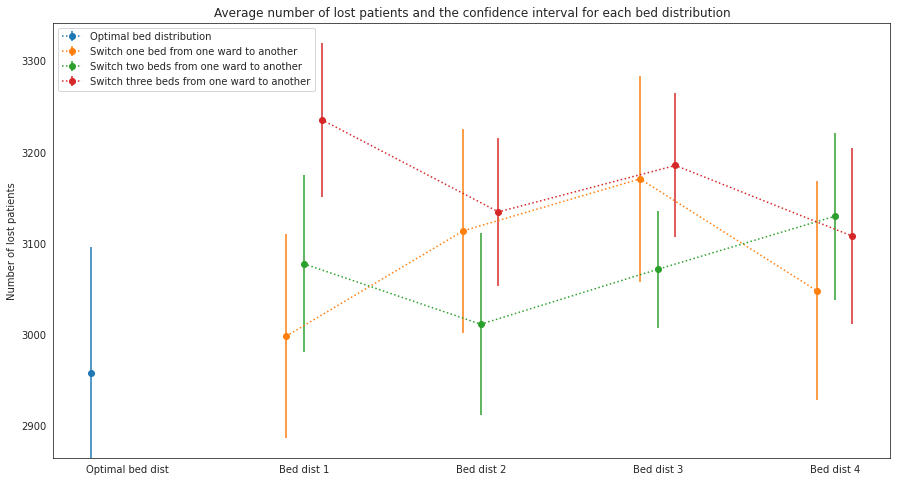

In [ ]:
def confidence_interval_sensitivity(bed_dist, df):
    X = []

    # Make 10 simulations for each distribution
    for i in range(10):
        df = initialize_patients(days=365)
        output_sim = simulate_hospital(bed_distribution=bed_dist, patients=df)
        # Calculate the number of lost patiens
        total, allocation, lost = summarize_allocation(output_sim)
        X.append(sum(lost))

    # Calculate the confidence interval
    conf = confidence_interval(X, alpha=0.05)
    return np.mean(X), conf[0]


def plot_errorplot():
    from matplotlib.transforms import Affine2D

    # Optimal bed distribution
    dist_mean, conf_min = confidence_interval_sensitivity(optimal_beds, df)
    # x: Name of the distrubtion to test
    x = ["Optimal bed dist"]

    # y: The average lost patients.
    y = [[dist_mean, np.nan, np.nan, np.nan, np.nan], [np.nan], [np.nan], [np.nan]]

    # error: The confidence interval
    errors = [
        [dist_mean - conf_min, np.nan, np.nan, np.nan, np.nan],
        [np.nan],
        [np.nan],
        [np.nan],
    ]

    # 4 randome bed distrubutions
    for i in range(4):
        x.append("Bed dist " + str(i + 1))

        # Choose two randome wands
        plus = random.randint(0, 5)
        minus = random.randint(0, 5)
        # Check that the choice is two different wards.
        while plus == minus:
            plus = random.randint(0, 5)
        # For each distribution swich one, two and tree number of beds
        for j in range(1, 4):
            optimal_beds_test = optimal_beds
            optimal_beds_test[plus] += 1
            optimal_beds_test[minus] -= 1
            print(
                "Bed dist" + str(i + 1), " (switch ", j, " beds): ", optimal_beds_test
            )
            dist_mean, conf_min = confidence_interval_sensitivity(optimal_beds_test, df)

            y[j].append(dist_mean)
            errors[j].append(dist_mean - conf_min)

    # Plot
    fig, ax = plt.subplots(figsize=(15, 8))

    ax.set(
        title="Average number of lost patients and the confidence interval for each bed distribution",
        ylabel="Number of lost patients",
    )

    trans0 = Affine2D().translate(-0.2, 0.0) + ax.transData
    trans1 = Affine2D().translate(-0.1, 0.0) + ax.transData
    trans2 = Affine2D().translate(0.0, 0.0) + ax.transData
    trans3 = Affine2D().translate(+0.1, 0.0) + ax.transData

    er0 = ax.errorbar(
        x,
        y[0],
        yerr=errors[0],
        marker="o",
        linestyle=":",
        transform=trans0,
        label="Optimal bed distribution",
    )
    er1 = ax.errorbar(
        x,
        y[1],
        yerr=errors[1],
        marker="o",
        linestyle=":",
        transform=trans1,
        label="Switch one bed from one ward to another",
    )
    er2 = ax.errorbar(
        x,
        y[2],
        yerr=errors[2],
        marker="o",
        linestyle=":",
        transform=trans2,
        label="Switch two beds from one ward to another",
    )
    er3 = ax.errorbar(
        x,
        y[3],
        yerr=errors[3],
        marker="o",
        linestyle=":",
        transform=trans3,
        label="Switch three beds from one ward to another",
    )

    ax.legend(loc="upper left")


plot_errorplot()

The hospital is sensitive to bed distribution, both to which ward the beds are switched between and how many beds there are switched. Unfortunately, we do "only" simulate ten hospitals per distribution, so the confidense intervals are large in almost every case. In a further sensitivity analysis, more simulation runs would be preferred to check the impact on the conficence interval.

## Total amount of beds

We want to test the system’s sensitivity when changing the total number of beds in the hospital. We are trying to increase and decrease the total number of beds by increasing the number of beds with one and decreasing the number of beds with one for each ward. We check the sensitivity in distribution by comparing the total number of lost patients. Therefore we simulate the hospital and calculate the total number of lost patients. 

In [ ]:
df = initialize_patients(days=365)
bed_sensitivity_plus = optimal_beds + 1
bed_sensitivity_minus = optimal_beds - 1

output_optimal = simulate_hospital(bed_distribution=optimal_beds, patients=df.copy())
output_sensitivity_plus = simulate_hospital(
    bed_distribution=bed_sensitivity_plus, patients=df.copy()
)
output_sensitivity_minus = simulate_hospital(
    bed_distribution=bed_sensitivity_minus, patients=df.copy()
)

KeyboardInterrupt: 

In [ ]:
print("Original bed capacity")
_134, allocation, lost = summarize_allocation(output_optimal)
# print('Table of allocation:\n', allocation)
print("Lost patients per ward:", lost)
print("Total lost patients", lost.sum())
print("Total relocated patients", expected_relocations_from(output_optimal).sum())
print()
print("Sensitivity bed capacity +1 bed per ward")
_, allocation, lost = summarize_allocation(output_sensitivity_plus)
# print('Table of allocation:\n', allocation)
print("Lost patients per ward:", lost)
print("Total lost patients", lost.sum())
print(
    "Total relocated patients", expected_relocations_from(output_sensitivity_plus).sum()
)
print()
print("Sensitivity bed capacity -1 bed per ward")
_, allocation, lost = summarize_allocation(output_sensitivity_minus)
print("Lost patients per ward:", lost)
print("Total lost patients", lost.sum())
print(
    "Total relocated patients",
    expected_relocations_from(output_sensitivity_minus).sum(),
)

Original bed capacity
Lost patients per ward: [921. 740. 697. 116. 608.  78.]
Total lost patients 3160.0
Total relocated patients 2886.0

Sensitivity bed capacity +1 bed per ward
Lost patients per ward: [843. 654. 596.  70. 547.  57.]
Total lost patients 2767.0
Total relocated patients 2753.0

Sensitivity bed capacity -1 bed per ward
Lost patients per ward: [1052.  801.  768.  188.  683.   93.]
Total lost patients 3585.0
Total relocated patients 2916.0


As can be seen, increasing the number of beds by 1 in each ward lowers the number of lost patients, but the number of relocated patients stays roughly the same. Having fewer beds i.e. reducing the number of beds by 1 ber ward causes both the lost patient count and the relocation count to increase as is expected. Even in this case, the relocation count seems less sensitive to the number of beds than the lost patient count.

The distribution of the number of occupied beds per ward is plotted to check the total number of beds in the hospital impact on occupied beds. We choose to make a plot of the first 30 days to get an idea of the distributions.

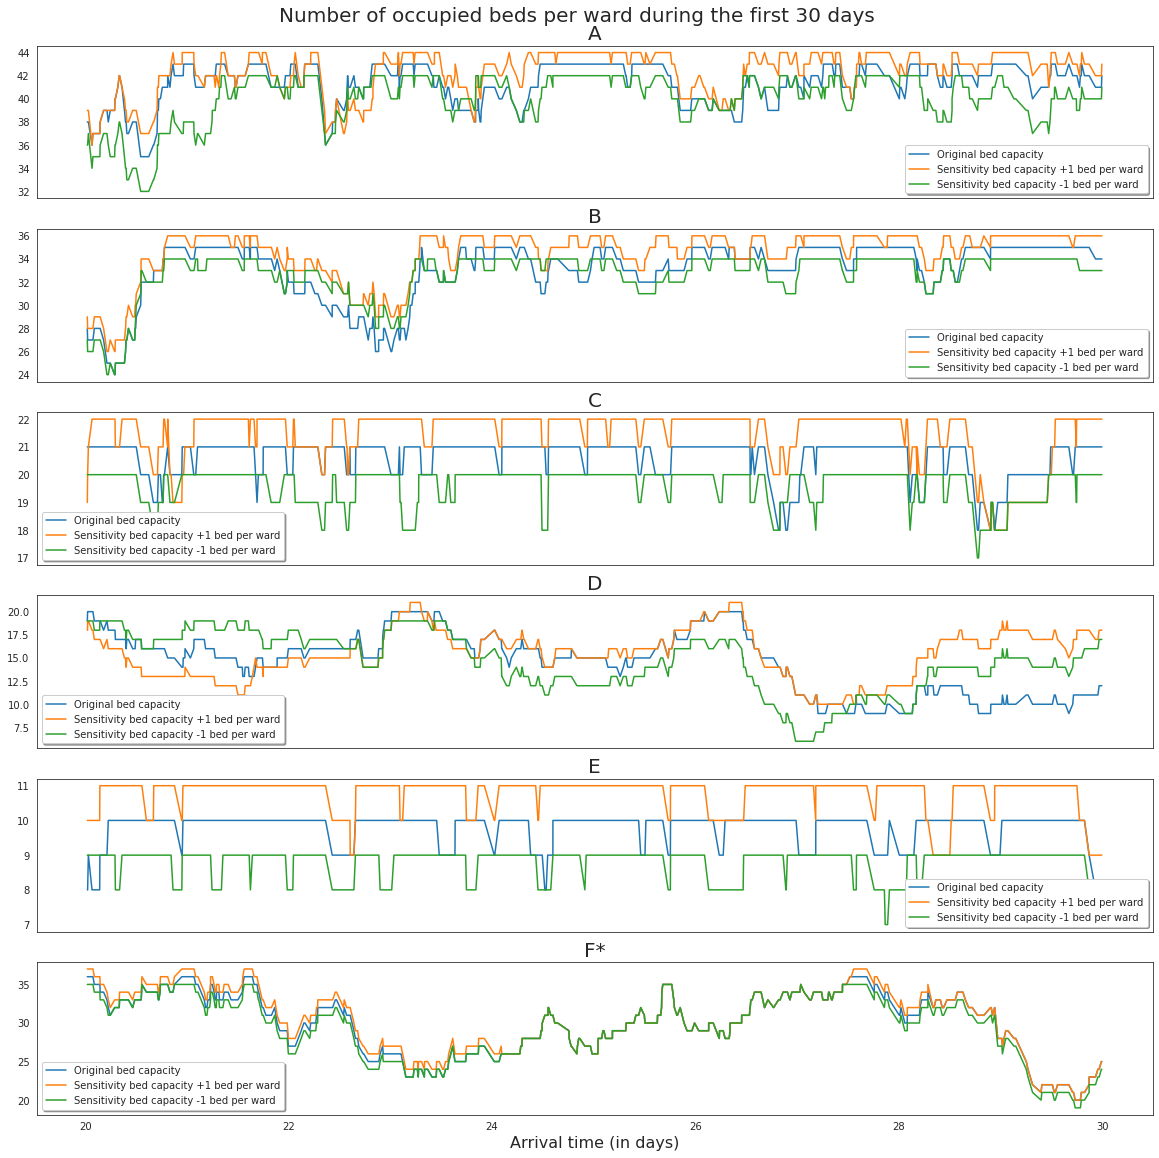

In [ ]:
def visualize_occupied_beds_sensitivity(
    output1, output2, output3, days, start_arrival=20
):
    df1 = output1["Dataframe"][output1["Dataframe"]["Arrival time"] < days]
    df2 = output2["Dataframe"][output2["Dataframe"]["Arrival time"] < days]
    df3 = output3["Dataframe"][output3["Dataframe"]["Arrival time"] < days]
    wards = ["A", "B", "C", "D", "E", "F*"]
    cols = [f"Ward {i} occupied beds" for i in wards]
    colors = ["C0", "C1", "C2", "C3", "C4", "C5"]

    t1 = df1["Arrival time"]
    t2 = df2["Arrival time"]
    t3 = df3["Arrival time"]

    i = 0
    fig, axes = plt.subplots(6, 1, figsize=(20, 18), sharex=True)
    for i, col in enumerate(cols):
        ax = axes[i]
        # ax.hlines(y=output1['Bed distribution'][i], xmin=min(t), xmax=max(t), color='red')
        ax.plot(
            t1[t1 > start_arrival],
            df1[col][t1 > start_arrival],
            c=colors[0],
            label="Original bed capacity",
        )
        ax.plot(
            t2[t2 > start_arrival],
            df2[col][t2 > start_arrival],
            c=colors[1],
            label="Sensitivity bed capacity +1 bed per ward",
        )
        ax.plot(
            t3[t3 > start_arrival],
            df3[col][t3 > start_arrival],
            c=colors[2],
            label="Sensitivity bed capacity -1 bed per ward",
        )
        # ax.legend(bbox_to_anchor=(0.5,0.30), fancybox=True, shadow=True)
        ax.set_title(wards[i], fontsize=20)
        ax.legend(fancybox=True, shadow=True)

    # plt.legend(loc="upper left")
    # plt.legend(fancybox=True, shadow=True)
    plt.subplots_adjust(top=0.95)
    plt.xlabel("Arrival time (in days)", fontsize=16)
    plt.suptitle(
        f"Number of occupied beds per ward during the first {days} days",
        fontsize=20,
    )


visualize_occupied_beds_sensitivity(
    output_optimal, output_sensitivity_plus, output_sensitivity_minus, days=30
)

The distribution of the number of beds occupied per ward is not sensitive to the total number of beds in the hospital. Increasing or decreasing the number of occupied beds follows roughly the same distribution with different upper bounds.

# Further considerations

How could this model, and its testing, be improved or extended? 

First, while we made sure to remove any initialization artificats from the arrival of patients, this is not the case for the allocation of beds. Indeed, the beds are all initialized empty and we observed that it takes roughly a week for the beds to be occupied close to the maximum capacity. Thus, the simulation of the hopistal reaches a steady state after a few days. The first few days are not representative of the normal state and have a small influence on some of the statistif collected and computed from the simulation. Hopefully, the hospital is simulated for one whole year and those initialization artificacts only account for around 2% of the simulation time. 

Secondly, a few more test could have been performed to validate that the simulation was implemented correctly. For example, to make sure that length-of-stay distributions followed exponential distributions, Kolmogorov-Smirnov tests could have been done. But as we explicitely sample from built-in exponential distributions this was not done. Another example of test would have been to do a $\chi^{2}$ test on the number of relocations from each ward to ensure the relocations follow the relocation probability distribution on each row of the relocation matrix given in the problem definition. However, as we do not record the alternative ward sampled when a patient is lost from the system, we do not retreive enough information to conduct this test. 

Thirdly, the confidence intervals are based on 10 simulations. A larger number would give better estimates but as each simulation takes a few seconds to run, increasing that number was not practical. Moreover, the variance of the estimators, i.e. the width of the confidence interval, could have been reduced using some variance reduction method. For example, control variates such as the empirical mean length-of-stay per patient type could have been used as we assume that they are positively (or negatively) correlacted to other estimates.


Lastly, we thought about re-using the random numbers when comparing two systems, $i.e.$ two simulations with different bed distributions. Rather than randomly initializing new patients, the same set of patients could be used for two simulations. Finally, an extension of the model could consider that the bed distribution varies, is a function of time. For example, the bed distribution. Imagine that the flow of patients for a certain type comes to a stop (e.g. the epidemic ends), the beds could then be re-distribution during the simulation.